# Figures for Ford et al. (2025)

This notebook includes the code required to reproduce the figures in Ford et al. (2025) that do not include feedback analyses, which are in a separate notebook.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from cartopy import crs as ccrs
import cartopy.feature as cf
import numpy as np
import matplotlib.patches as mpatches
from scipy.stats import linregress, pearsonr
import xesmf as xe
import glob, os
import s3fs
import fsspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from climlab.utils.constants import a, g
from climlab.utils.thermo import EIS

Define a global average function and a function that extends the data in longitude for plotting (to remove the line that appears in Cartopy plots):

In [2]:
def global_average(data, lon=True):
    weights = np.cos(np.deg2rad(data.lat))
    data_weighted = data.weighted(weights)
    if lon == True: 
        return data_weighted.mean(dim=['lat', 'lon'], skipna=True)
    else: return data_weighted.mean(dim='lat', skipna=True)

def add_cyclic_point(xarray_obj, dim='lon', period=360):
    first_point = xarray_obj.isel({dim: slice(1)})
    first_point.coords[dim] = first_point.coords[dim]+period
    return xr.concat([xarray_obj, first_point], dim=dim)

## Loading in data

### Remote access from the Pythia Jetstream2 object store

In [3]:
URL = 'https://js2.jetstream-cloud.org:8001/'
path = f'pythia/OHUTCR-data'
fs = fsspec.filesystem("s3", anon=True, client_kwargs=dict(endpoint_url=URL))
pattern = f's3://{path}/*.nc'
files = sorted(fs.glob(pattern))
files

['pythia/OHUTCR-data/CESM1-CAM5_CO2.cam.h0.mean.nc',
 'pythia/OHUTCR-data/CESM1-CAM5_ctrl.cam.h0.mean.nc',
 'pythia/OHUTCR-data/OHUTCR-feedbacks.nc',
 'pythia/OHUTCR-data/cmip5em-tcr-mean-output.nc',
 'pythia/OHUTCR-data/cold4-model-tcr-mean-output.nc',
 'pythia/OHUTCR-data/pop_frc.b.e11.B1850C5CN.f19_g16.130429.nc',
 'pythia/OHUTCR-data/warm13-model-tcr-mean-output.nc']

In [4]:
fileset = [fs.open(file) for file in files]
fileset

[<File-like object S3FileSystem, pythia/OHUTCR-data/CESM1-CAM5_CO2.cam.h0.mean.nc>,
 <File-like object S3FileSystem, pythia/OHUTCR-data/CESM1-CAM5_ctrl.cam.h0.mean.nc>,
 <File-like object S3FileSystem, pythia/OHUTCR-data/OHUTCR-feedbacks.nc>,
 <File-like object S3FileSystem, pythia/OHUTCR-data/cmip5em-tcr-mean-output.nc>,
 <File-like object S3FileSystem, pythia/OHUTCR-data/cold4-model-tcr-mean-output.nc>,
 <File-like object S3FileSystem, pythia/OHUTCR-data/pop_frc.b.e11.B1850C5CN.f19_g16.130429.nc>,
 <File-like object S3FileSystem, pythia/OHUTCR-data/warm13-model-tcr-mean-output.nc>]

### Response data

| Name in this notebook     | Name in the paper |
| ----------- | ----------- |
| `ctrl` | Control |
| `response` | Ensemble |
| `resp_em` | CM Q-flux |
| `resp_cold` | +$\Delta$SIC |
| `resp_co2` | 2xCO2 only |

In [6]:
ctrl = xr.open_dataset(fileset[1]).isel(time=0).drop('time')
response = xr.open_dataset(fileset[6]).drop_sel(model='GFDL-ESM2G')
resp_em = xr.open_dataset(fileset[3])
resp_cold = xr.open_dataset(fileset[4]).drop_sel(model='ACCESS1-0')
resp_co2 = xr.open_dataset(fileset[0]).isel(time=0).drop('time')

### Q-flux data

In [7]:
ctrl_qf = xr.open_dataset(fileset[5])
models_warm = ['BNU-ESM', 'MIROC-ESM', 'NorESM1-ME', 
               'inmcm4', 'MRI-CGCM3', 'CESM1-BGC', 'NorESM1-M', 'bcc-csm1-1-m', 
               'CNRM-CM5-2', 'CCSM4', 'bcc-csm1-1', 'CSIRO-Mk3-6-0']
models_cold = ['CNRM-CM5', 'MIROC5', 'ACCESS1-3']

filenames = []
for model in models_warm:
    filenames.append('hfds_Omon_'+model+'_anom_r1i1p1_1x1_monthly_mean.nc')

filepath = './hfds_TCR_diff_1x1/'
temp_hfds_dataset = [xr.open_dataset(filepath + filename, decode_times=False).mean(dim='time') for filename in filenames]
hfds_dataset = xr.concat(temp_hfds_dataset, response.model)

cfilenames = []
for model in models_cold:
    cfilenames.append('hfds_Omon_'+model+'_anom_r1i1p1_1x1_monthly_mean.nc')

ctemp_hfds_dataset = [xr.open_dataset(filepath + filename, decode_times=False).mean(dim='time') for filename in cfilenames]
chfds_dataset = xr.concat(ctemp_hfds_dataset, resp_cold.model)

In [8]:
chfds_dataset

<xarray.Dataset>
Dimensions:  (lon: 360, lat: 180, model: 3)
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * model    (model) object 'CNRM-CM5' 'MIROC5' 'ACCESS1-3'
Data variables:
    hfds     (model, lat, lon) float32 nan nan nan nan ... 1.004 1.006 1.009

## Figure 1: Q-flux maps

Regrid control Q-flux to 1x1 grid:

In [9]:
ctrl_qf_rn = ctrl_qf.mean(dim='time').rename({'xc': 'lon', 'yc': 'lat'})

ds_out = xe.util.grid_global(1, 1)
regridder = xe.Regridder(ctrl_qf_rn, ds_out, 'bilinear')
regr_ctrl_qf = regridder(ctrl_qf_rn.qdp)

Calculate Q-flux multimodel-mean:

In [10]:
qflux_model_mean = hfds_dataset.hfds.mean(dim='model')
qflux_model_sd = hfds_dataset.hfds.std(dim='model')
qflux_model_anom = hfds_dataset.hfds - qflux_model_mean

Calculate global-mean surface temperature (for coloring individual model zonal-mean Q-flux anomalies):

In [11]:
gmst = global_average(response.TREFHT)

Fill in a line of missing data resulting from the regridding. This has no effect on the analysis; it is only for plotting:

In [12]:
regr_ctrl_qf_filled = regr_ctrl_qf.where(regr_ctrl_qf != 0).bfill(dim='x')

The plot:

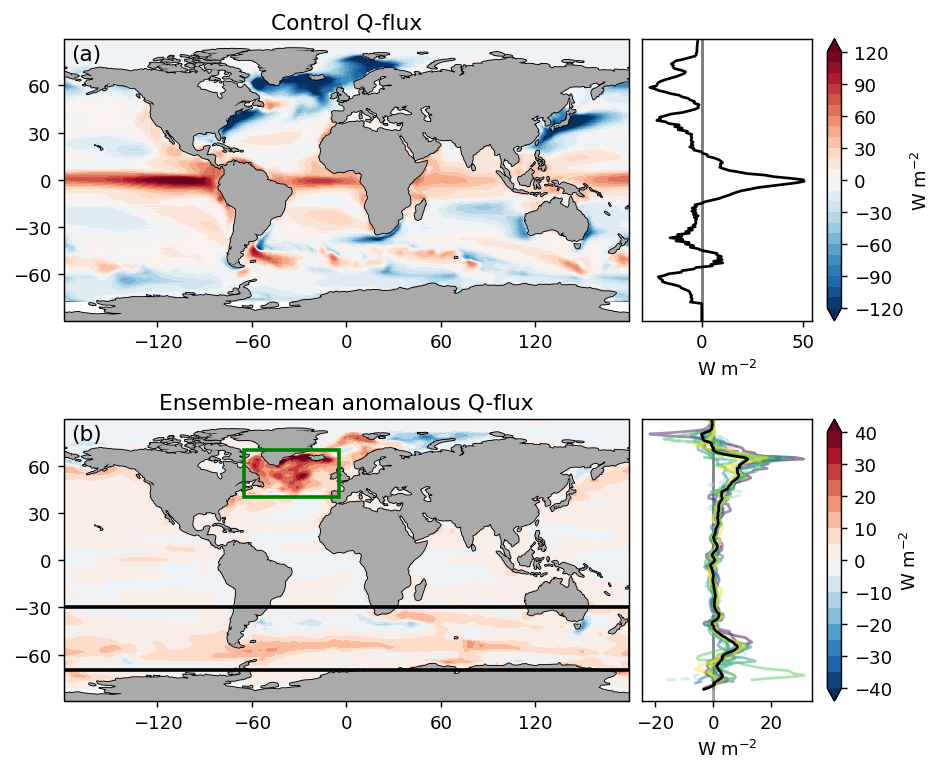

In [13]:
feature = cf.NaturalEarthFeature(
    name='land', category='physical',
    scale='110m',
    facecolor='#AAAAAA')

fig = plt.figure(figsize=(8, 6), dpi=130)
ax_mean = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree())
mean_plot = ax_mean.contourf(qflux_model_mean.lon, qflux_model_mean.lat, qflux_model_mean, cmap='RdBu_r', levels=np.arange(-40, 41, 5), norm=colors.CenteredNorm(), extend='both')
ax_mean.coastlines()
ax_mean.add_feature(feature)
ax_mean.set_xticks([-120, -60, 0, 60, 120], crs=ccrs.PlateCarree())
ax_mean.set_yticks([-60, -30, 0, 30, 60], crs=ccrs.PlateCarree())
plt.colorbar(mean_plot, orientation='vertical', label='W m$^{-2}$', pad=-0.03)
plt.text(-175, 76, '(b)', fontdict={'size': 12})

divider = make_axes_locatable(ax_mean)
ax3 = divider.new_horizontal(size="30%", pad=0.1, axes_class=plt.Axes)
fig.add_axes(ax3)
ax3.set_yticks([])
    
ax3.plot(0*qflux_model_mean.lat, qflux_model_mean.lat, color='gray', linestyle='-')
for j, m in enumerate(models_cold):
    plt.plot(chfds_dataset.hfds.isel(model=j).mean(dim='lon'), chfds_dataset.lat, color='lightblue', linestyle='--', alpha=0.5)

for j, m in enumerate(models_warm):
    ax3.plot(hfds_dataset.hfds.isel(model=j).mean(dim='lon'), hfds_dataset.lat, color=plt.cm.viridis(((gmst-gmst.min())/(gmst-gmst.min()).max()).sel(model=m)), alpha=0.5)
    
mz_plot = ax3.plot(hfds_dataset.hfds.mean(dim=['lon', 'model']), qflux_model_mean.lat, 'k')

ax3.set_ylim(-90, 90)
ax3.set_xlabel('W m$^{-2}$')

ax_sd = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
sd_plot = ax_sd.contourf(regr_ctrl_qf_filled.lon, regr_ctrl_qf_filled.lat, regr_ctrl_qf_filled, cmap='RdBu_r', levels=np.arange(-120, 121, 10), norm=colors.CenteredNorm(), extend='both')
ax_sd.coastlines()
ax_sd.add_feature(feature)
ax_sd.set_xticks([-120, -60, 0, 60, 120], crs=ccrs.PlateCarree())
ax_sd.set_yticks([-60, -30, 0, 30, 60], crs=ccrs.PlateCarree())
plt.colorbar(sd_plot, orientation='vertical', label='W m$^{-2}$', pad=-0.03)
plt.text(-175, 76, '(a)', fontdict={'size': 12})

ax_mean.add_patch(mpatches.Rectangle(xy=[-180, -70], width=360, height=40, facecolor='none', edgecolor='k', linewidth=2, alpha=1, transform=ccrs.PlateCarree(), zorder=3))
ax_mean.add_patch(mpatches.Rectangle(xy=[-65, 40], width=60, height=30, facecolor='none', edgecolor='g', linewidth=2, alpha=1, transform=ccrs.PlateCarree(), zorder=3))

divider2 = make_axes_locatable(ax_sd)
ax5 = divider2.new_horizontal(size="30%", pad=0.1, axes_class=plt.Axes)
fig.add_axes(ax5)
ax5.set_yticks([])
    
ax5.plot(0*regr_ctrl_qf.lat, regr_ctrl_qf.lat, color='gray', linestyle='-')
sdz_plot = ax5.plot(regr_ctrl_qf.mean(dim='x'), regr_ctrl_qf.y - 90, 'k')
ax5.set_ylim(-90, 90)
ax5.set_xlabel('W m$^{-2}$')

ax_sd.set_title('Control Q-flux')
ax_mean.set_title('Ensemble-mean anomalous Q-flux')
plt.tight_layout()

## Figure 2: OHU-TCR correlation

Compute TCR:

In [14]:
tcr = global_average(response.TREFHT - ctrl.TREFHT)
em_tcr = global_average(resp_em.TREFHT - ctrl.TREFHT)
c_tcr = global_average(resp_cold.TREFHT - ctrl.TREFHT) # Note that we do not interpret this response as TCR in the paper

Compute region-average Q-fluxes:

In [15]:
soqf = global_average(hfds_dataset.hfds.where((hfds_dataset.lat > -70) & (hfds_dataset.lat < -30)))
naqf = global_average(hfds_dataset.hfds.where((hfds_dataset.lat > 40) & (hfds_dataset.lat < 70) & (hfds_dataset.lon > -65) & (hfds_dataset.lon < -5)))
gmqf = global_average(hfds_dataset.hfds)

em_soqf = global_average(hfds_dataset.mean(dim='model').hfds.where((hfds_dataset.lat > -70) & (hfds_dataset.lat < -30)))
em_naqf = global_average(hfds_dataset.mean(dim='model').hfds.where((hfds_dataset.lat > 40) & (hfds_dataset.lat < 70) & (hfds_dataset.lon > -65) & (hfds_dataset.lon < -5)))
em_gmqf = global_average(hfds_dataset.mean(dim='model').hfds)

c_soqf = global_average(chfds_dataset.hfds.where((chfds_dataset.lat > -70) & (chfds_dataset.lat < -30)))
c_naqf = global_average(chfds_dataset.hfds.where((chfds_dataset.lat > 40) & (chfds_dataset.lat < 70) & (chfds_dataset.lon > -65) & (chfds_dataset.lon < -5)))
c_gmqf = global_average(chfds_dataset.hfds)

In [16]:
tcr

<xarray.DataArray 'TREFHT' (model: 12)>
array([1.10899403, 1.18807893, 1.43917641, 1.46005019, 1.60642573,
       1.63782021, 1.69910473, 1.7312974 , 1.81213764, 1.85868101,
       2.03546641, 2.04494105])
Coordinates:
  * model    (model) object 'BNU-ESM' 'MIROC-ESM' ... 'CSIRO-Mk3-6-0'

The plot:

In [17]:
c_tcr.model.values

array(['CNRM-CM5', 'MIROC5', 'ACCESS1-3'], dtype=object)

Text(0.015, 0.98, '(c)')

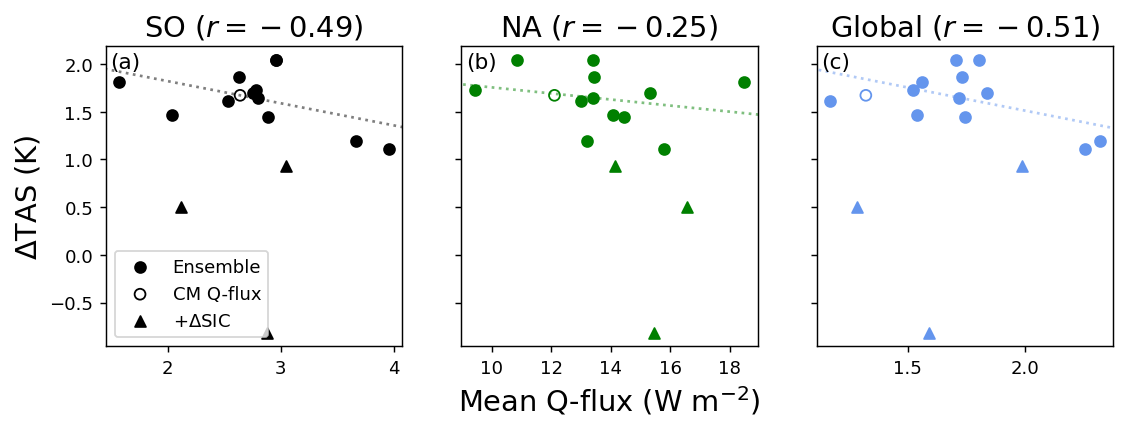

In [18]:
fig = plt.figure(figsize=(10, 3), dpi=130)

x = np.linspace(-100, 100, 20)

z1 = np.polyfit(soqf, tcr, 1)
m1, b1 = z1[0], z1[1]
ax1 = plt.subplot(1, 3, 1)
ax1.scatter(soqf, tcr, color='k', label='Ensemble')
ax1.scatter(em_soqf, em_tcr, color='k', facecolors='none', label='CM Q-flux')
ax1.scatter(c_soqf, c_tcr, color='k', marker='^', label='$+\Delta$SIC')
xlim1 = ax1.get_xlim()
ylim1 = ax1.get_ylim()
ax1.plot(x, m1*x+b1, color='k', linestyle=':', alpha=0.5)
ax1.set_ylabel('$\Delta$TAS (K)', fontsize=16)
ax1.set_title('SO ($r=%.2f$)' %pearsonr(soqf, tcr)[0], fontsize=16)
ax1.set_ylim(ylim1)
ax1.set_xlim(xlim1)
ax1.legend()

z2 = np.polyfit(naqf, tcr, 1)
m2, b2 = z2[0], z2[1]
ax2 = plt.subplot(1, 3, 2, sharey=ax1)
ax2.scatter(naqf, tcr, color='g')
ax2.scatter(em_naqf, em_tcr, color='g', facecolors='none')
ax2.scatter(c_naqf, c_tcr, color='g', marker='^')
xlim2 = ax2.get_xlim()
ylim2 = ax2.get_ylim()
ax2.plot(x, m2*x+b2, color='g', linestyle=':', alpha=0.5)
ax2.tick_params('y', labelleft=False)
ax2.set_xlabel('Mean Q-flux (W m$^{-2}$)', fontsize=16)
ax2.set_title('NA ($r=%.2f$)' %pearsonr(naqf, tcr)[0], fontsize=16)
ax2.set_ylim(ylim2)
ax2.set_xlim(xlim2)

z3 = np.polyfit(gmqf, tcr, 1)
m3, b3 = z3[0], z3[1]
ax3 = plt.subplot(1, 3, 3, sharey=ax1)
ax3.scatter(gmqf, tcr, color='cornflowerblue')
# for i, m in enumerate(tcr.model):
#     ax3.text(gmqf.isel(model=i), tcr.sel(model=m), m.values)
ax3.scatter(em_gmqf, em_tcr, color='cornflowerblue', facecolors='none')
ax3.scatter(c_gmqf, c_tcr, color='cornflowerblue', marker='^')
xlim3 = ax3.get_xlim()
ylim3 = ax3.get_ylim()
ax3.plot(x, m3*x+b3, color='cornflowerblue', linestyle=':', alpha=0.5)
ax3.tick_params('y', labelleft=False)
ax3.set_title('Global ($r=%.2f$)' %pearsonr(gmqf, tcr)[0], fontsize=16)
ax3.set_ylim(ylim3)
ax3.set_xlim(xlim3)

ax1.text(.015, .98, '(a)', ha='left', va='top', transform=ax1.transAxes, fontsize=12)
ax2.text(.015, .98, '(b)', ha='left', va='top', transform=ax2.transAxes, fontsize=12)
ax3.text(.015, .98, '(c)', ha='left', va='top', transform=ax3.transAxes, fontsize=12)

## Figure 3: Response

Compute TAS response:

In [19]:
gmst = global_average(response.TREFHT)

tcr_map = response.TREFHT - ctrl.TREFHT
cold_tcr_map = resp_cold.TREFHT - ctrl.TREFHT
em_tcr_map = resp_em.TREFHT - ctrl.TREFHT
ecs_map = resp_co2.TREFHT - ctrl.TREFHT

Compute SIC response:

In [20]:
sic = (response.ICEFRAC - ctrl.ICEFRAC)*100
cold_sic = (resp_cold.ICEFRAC - ctrl.ICEFRAC)*100
em_sic = (resp_em.ICEFRAC - ctrl.ICEFRAC)*100
co2_sic = (resp_co2.ICEFRAC - ctrl.ICEFRAC)*100

Zonal averages:

In [21]:
zm_tcr = tcr_map.mean(dim='lon')
zm_sic = sic.mean(dim='lon')

cold_zm_tcr = cold_tcr_map.mean(dim='lon')
cold_zm_sic = cold_sic.mean(dim='lon')

zm_em_tcr = em_tcr_map.mean(dim='lon')
zm_em_sic = em_sic.mean(dim='lon')

zm_co2_ecs = ecs_map.mean(dim='lon')
zm_co2_sic = co2_sic.mean(dim='lon')

The plot:

In [22]:
# cyclic_tcr = add_cyclic_point(tcr_map)
# cyclic_cold_tcr = add_cyclic_point(cold_tcr_map)
# cyclic_sic = add_cyclic_point(sic)
# cyclic_cold_sic = add_cyclic_point(cold_sic)

# fig = plt.figure(dpi=130, figsize=(12, 8))

# axt = plt.subplot(221, projection=ccrs.PlateCarree())
# t_plot = axt.contourf(cyclic_tcr.lon, cyclic_tcr.lat, cyclic_tcr.mean(dim='model'), cmap='RdBu_r', norm=colors.CenteredNorm(), levels=np.arange(-2, 12, 1))
# axt.contour(cyclic_tcr.lon, cyclic_tcr.lat, cyclic_tcr.mean(dim='model'), colors='k', levels=[0.0], linestyles='--', linewidths=1)
# axt.coastlines(linewidths=0.75)
# plt.colorbar(t_plot, orientation='horizontal', label='$\Delta$TAS (K)', pad=-0.03)

# axtc = plt.subplot(222, projection=ccrs.PlateCarree())
# tc_plot = axtc.contourf(cyclic_cold_tcr.lon, cyclic_cold_tcr.lat, cyclic_cold_tcr.mean(dim='model'), cmap='RdBu_r', norm=colors.CenteredNorm(),)
# axtc.contour(cyclic_cold_tcr.lon, cyclic_cold_tcr.lat, cyclic_cold_tcr.mean(dim='model'), colors='k', levels=[0.0], linestyles='--', linewidths=1)
# axtc.coastlines(linewidths=0.75)
# plt.colorbar(tc_plot, orientation='horizontal', label='$\Delta$TAS (K)', pad=-0.03)

# axs = plt.subplot(223, projection=ccrs.PlateCarree())
# s_plot = axs.contourf(cyclic_sic.lon, cyclic_sic.lat, cyclic_sic.mean(dim='model'), cmap='RdBu_r', norm=colors.CenteredNorm(), levels=np.arange(-48, 9, 4))
# axs.coastlines(linewidths=0.75)
# plt.colorbar(s_plot, orientation='horizontal', label='$\Delta$SIC (%)', pad=-0.03)

# divider = make_axes_locatable(axt)
# ax1 = divider.new_horizontal(size="30%", pad=0.1, axes_class=plt.Axes)
# fig.add_axes(ax1)
# ax1.set_yticks([])

# ax1.plot(0*zm_tcr.lat, zm_tcr.lat, linestyle='-', color='gray')

# for i, m in enumerate(zm_tcr.model):
#     ax1.plot(zm_tcr.sel(model=m), zm_tcr.lat, color=plt.cm.viridis(((gmst-gmst.min())/(gmst-gmst.min()).max())[i]), linestyle='-', alpha=0.5)

# ax1.plot(zm_tcr.mean(dim='model'), zm_tcr.lat, color='k', linewidth=3, label='Ens. mean')
# ax1.plot(zm_co2_ecs, ecs_map.lat, color='r', linestyle='--', linewidth=1.5, label='2xCO2 only')
# ax1.plot(zm_em_tcr, zm_em_tcr.lat, color='b', linestyle='--', linewidth=1.5, label='CM Q-flux')

# for i, m in enumerate(cold_zm_tcr.model):
#     if i == 0:
#         ax1.plot(cold_zm_tcr.sel(model=m), cold_zm_tcr.lat, color='cornflowerblue', linestyle='--', alpha=0.5, label='+$\Delta$SIC')
#     else:
#         ax1.plot(cold_zm_tcr.sel(model=m), cold_zm_tcr.lat, color='cornflowerblue', linestyle='--', alpha=0.5)

# divider2 = make_axes_locatable(axs)
# ax2 = divider2.new_horizontal(size="30%", pad=0.1, axes_class=plt.Axes)
# fig.add_axes(ax2)
# ax2.set_yticks([])

# ax2.plot(0*zm_sic.lat, zm_sic.lat, linestyle='-', color='gray')

# for i, m in enumerate(zm_tcr.model):
#     ax2.plot(zm_sic.sel(model=m), zm_sic.lat, color=plt.cm.viridis(((gmst-gmst.min())/(gmst-gmst.min()).max())[i]), linestyle='-', alpha=0.5)
    
# ax2.plot(zm_sic.mean(dim='model'), zm_sic.lat, color='k', linewidth=3, label='Ens. mean')
# ax2.plot(zm_co2_sic, ecs_map.lat, color='r', linestyle='--', linewidth=1.5, label='2xCO2 only')
# ax2.plot(zm_em_sic, zm_em_sic.lat, color='b', linestyle='--', linewidth=1.5, label='CM Q-flux')

# for i, m in enumerate(cold_zm_tcr.model):
#     if i == 0:
#         ax2.plot(cold_zm_sic.sel(model=m), cold_zm_sic.lat, color='cornflowerblue', linestyle='--', alpha=0.5, label='+$\Delta$SIC')
#     elif i != 0:
#         ax2.plot(cold_zm_sic.sel(model=m), cold_zm_sic.lat, color='cornflowerblue', linestyle='--', alpha=0.5)

# ax2.legend(prop = {'size': 9})
# ax1.set_ylim(-90, 90)
# ax2.set_ylim(-90, 90)
# ax2.set_xlim(-20, 40)
# ax1.set_xlabel('K')
# ax2.set_xlabel('%')

# axt.set_xticks([-120, -60, 0, 60, 120], crs=ccrs.PlateCarree())
# axt.set_yticks([-60, -30, 0, 30, 60], crs=ccrs.PlateCarree())
# axs.set_xticks([-120, -60, 0, 60, 120], crs=ccrs.PlateCarree())
# axs.set_yticks([-60, -30, 0, 30, 60], crs=ccrs.PlateCarree())

# feature = cf.NaturalEarthFeature(
#     name='land', category='physical',
#     scale='110m',
#     facecolor='#AAAAAA')
# axs.add_feature(feature)

# axt.set_title('Ensemble-mean change in TAS')
# axs.set_title('Ensemble-mean change in SIC')
# plt.tight_layout()

Text(0.5, 1.0, '$+\\Delta$SIC-mean change in SIC')

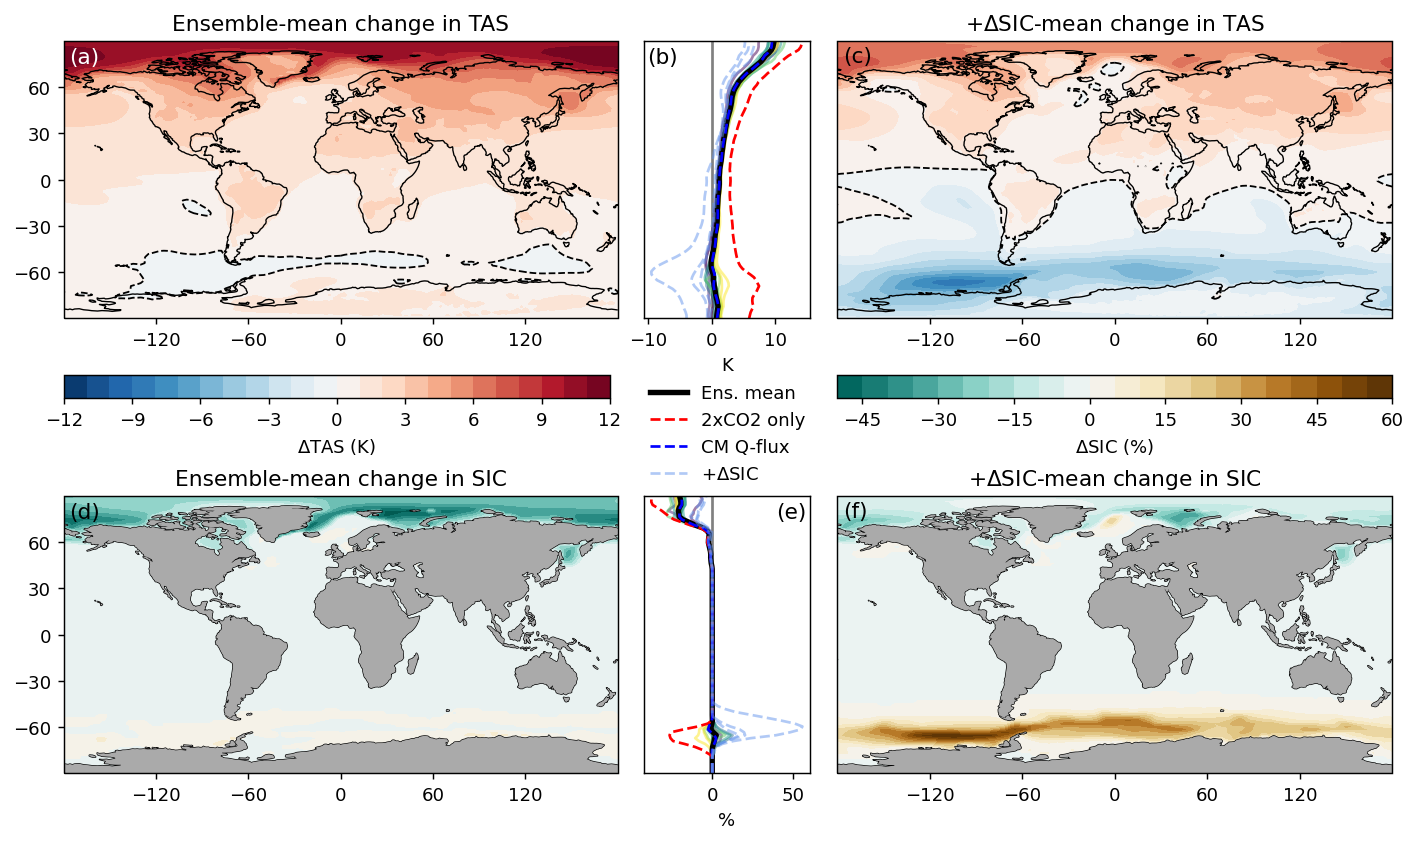

In [23]:
cyclic_tcr = add_cyclic_point(tcr_map)
cyclic_cold_tcr = add_cyclic_point(cold_tcr_map)
cyclic_sic = add_cyclic_point(sic)
cyclic_cold_sic = add_cyclic_point(cold_sic)

fig = plt.figure(dpi=130, figsize=(14, 7))

# Temperature axes

axt = fig.add_axes([0, 0.5, 0.41, 0.4], projection=ccrs.PlateCarree())

divider = make_axes_locatable(axt)
axtz = divider.new_horizontal(size="30%", pad=0.2, axes_class=plt.Axes)
fig.add_axes(axtz)

axtc = fig.add_axes([0.425, 0.5, 0.305, 0.4], projection=ccrs.PlateCarree())

# Sea ice axes

axs = fig.add_axes([0, 0, 0.41, 0.4], projection=ccrs.PlateCarree())

divider2 = make_axes_locatable(axs)
axsz = divider2.new_horizontal(size="30%", pad=0.2, axes_class=plt.Axes)
fig.add_axes(axsz)

axsc = fig.add_axes([0.425, 0, 0.305, 0.4], projection=ccrs.PlateCarree())

#Color bars

axcbt = fig.add_axes([0, 0.46, 0.3, 0.025])
axcbs = fig.add_axes([0.425, 0.46, 0.305, 0.025])

# Temperature plots

t_plot = axt.contourf(cyclic_tcr.lon, cyclic_tcr.lat, cyclic_tcr.mean(dim='model'), cmap='RdBu_r', norm=colors.CenteredNorm(), levels=np.arange(-2, 12, 1))
axt.contour(cyclic_tcr.lon, cyclic_tcr.lat, cyclic_tcr.mean(dim='model'), colors='k', levels=[0.0], linestyles='--', linewidths=1)
axt.coastlines(linewidths=0.75)

tc_plot = axtc.contourf(cyclic_cold_tcr.lon, cyclic_cold_tcr.lat, cyclic_cold_tcr.mean(dim='model'), cmap='RdBu_r', norm=colors.CenteredNorm(), levels=np.arange(-12, 13, 1))
axtc.contour(cyclic_cold_tcr.lon, cyclic_cold_tcr.lat, cyclic_cold_tcr.mean(dim='model'), colors='k', levels=[0.0], linestyles='--', linewidths=1)
axtc.coastlines(linewidths=0.75)
plt.colorbar(tc_plot, cax=axcbt, orientation='horizontal', label='$\Delta$TAS (K)', pad=-0.03)

axtz.plot(0*zm_tcr.lat, zm_tcr.lat, linestyle='-', color='gray')

for i, m in enumerate(zm_tcr.model):
    axtz.plot(zm_tcr.sel(model=m), zm_tcr.lat, color=plt.cm.viridis(((gmst-gmst.min())/(gmst-gmst.min()).max())[i]), linestyle='-', alpha=0.5)

axtz.plot(zm_tcr.mean(dim='model'), zm_tcr.lat, color='k', linewidth=3, label='Ens. mean')
axtz.plot(zm_co2_ecs, ecs_map.lat, color='r', linestyle='--', linewidth=1.5, label='2xCO2 only')
axtz.plot(zm_em_tcr, zm_em_tcr.lat, color='b', linestyle='--', linewidth=1.5, label='CM Q-flux')

for i, m in enumerate(cold_zm_tcr.model):
    if i == 0:
        axtz.plot(cold_zm_tcr.sel(model=m), cold_zm_tcr.lat, color='cornflowerblue', linestyle='--', alpha=0.5, label='+$\Delta$SIC')
    else:
        axtz.plot(cold_zm_tcr.sel(model=m), cold_zm_tcr.lat, color='cornflowerblue', linestyle='--', alpha=0.5)

# Sea ice plots

s_plot = axs.contourf(cyclic_sic.lon, cyclic_sic.lat, cyclic_sic.mean(dim='model'), cmap='BrBG_r', norm=colors.CenteredNorm(), levels=np.arange(-50, 11, 5))
axs.coastlines(linewidths=0.75)
#plt.colorbar(s_plot, cax=axcbs, orientation='horizontal', label='$\Delta$SIC (%)', pad=-0.03)

sc_plot = axsc.contourf(cyclic_cold_sic.lon, cyclic_cold_sic.lat, cyclic_cold_sic.mean(dim='model'), cmap='BrBG_r', norm=colors.CenteredNorm(), levels=np.arange(-50, 61, 5))
axsc.coastlines(linewidths=0.75)
plt.colorbar(sc_plot, cax=axcbs, orientation='horizontal', label='$\Delta$SIC (%)', pad=-0.03)

landmask = cf.NaturalEarthFeature(
    name='land', category='physical',
    scale='110m',
    facecolor='#AAAAAA')
axs.add_feature(landmask)
axsc.add_feature(landmask)

axsz.plot(0*zm_sic.lat, zm_sic.lat, linestyle='-', color='gray')

for i, m in enumerate(zm_tcr.model):
    axsz.plot(zm_sic.sel(model=m), zm_sic.lat, color=plt.cm.viridis(((gmst-gmst.min())/(gmst-gmst.min()).max())[i]), linestyle='-', alpha=0.5)

# for i, m in enumerate(zm_tcr.model):
#     axsz.plot(zm_sic.sel(model=m), zm_sic.lat, color='grey', linestyle='-', alpha=0.5)
    
axsz.plot(zm_sic.mean(dim='model'), zm_sic.lat, color='k', linewidth=3, label='Ens. mean')
axsz.plot(zm_co2_sic, ecs_map.lat, color='r', linestyle='--', linewidth=1.5, label='2xCO2 only')
axsz.plot(zm_em_sic, zm_em_sic.lat, color='b', linestyle='--', linewidth=1.5, label='CM Q-flux')

for i, m in enumerate(cold_zm_tcr.model):
    if i == 0:
        axsz.plot(cold_zm_sic.sel(model=m), cold_zm_sic.lat, color='cornflowerblue', linestyle='--', alpha=0.5, label='+$\Delta$SIC')
    elif i != 0:
        axsz.plot(cold_zm_sic.sel(model=m), cold_zm_sic.lat, color='cornflowerblue', linestyle='--', alpha=0.5)

axtz.legend(frameon=False, prop = {'size': 10}, bbox_to_anchor=(1.07, -0.18))
axtz.set_ylim(-90, 90)
axsz.set_ylim(-90, 90)
axtz.set_xlabel('K')
axsz.set_xlabel('%')
axtz.set_yticks([])
axsz.set_yticks([])

axt.set_xticks([-120, -60, 0, 60, 120], crs=ccrs.PlateCarree())
axt.set_yticks([-60, -30, 0, 30, 60], crs=ccrs.PlateCarree())
axs.set_xticks([-120, -60, 0, 60, 120], crs=ccrs.PlateCarree())
axs.set_yticks([-60, -30, 0, 30, 60], crs=ccrs.PlateCarree())
axtc.set_xticks([-120, -60, 0, 60, 120], crs=ccrs.PlateCarree())
#axtc.set_yticks([-60, -30, 0, 30, 60], crs=ccrs.PlateCarree())
axsc.set_xticks([-120, -60, 0, 60, 120], crs=ccrs.PlateCarree())
#axsc.set_yticks([-60, -30, 0, 30, 60], crs=ccrs.PlateCarree())

axt.text(.01, .98, '(a)', ha='left', va='top', transform=axt.transAxes, fontsize=12, color='w')
axtz.text(.02, .98, '(b)', ha='left', va='top', transform=axtz.transAxes, fontsize=12)
axtc.text(.01, .98, '(c)', ha='left', va='top', transform=axtc.transAxes, fontsize=12)
axs.text(.01, .98, '(d)', ha='left', va='top', transform=axs.transAxes, fontsize=12)
axsz.text(.98, .98, '(e)', ha='right', va='top', transform=axsz.transAxes, fontsize=12)
axsc.text(.01, .98, '(f)', ha='left', va='top', transform=axsc.transAxes, fontsize=12)

axt.set_title('Ensemble-mean change in TAS')
axs.set_title('Ensemble-mean change in SIC')
axtc.set_title('$+\Delta$SIC-mean change in TAS')
axsc.set_title('$+\Delta$SIC-mean change in SIC')

In [24]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
            
        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
            
        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

fsspec==2022.7.1
xarray==2022.6.0
matplotlib==3.5.3
numpy==1.22.4
xesmf==0.6.3
s3fs==0.4.2


## Figure 4: Hadley circulation shift

Define the mass streamfunction $\psi$:

In [25]:
def psi(ds):
    coslat = np.cos(np.deg2rad(ds.lat))
    psi = 2*np.pi*a*coslat/g * ds.V.mean(dim='lon').cumulative_integrate(coord='lev') / 1E9 * 100
    return psi

Calculate $\psi$ and $\Delta\psi$:

In [26]:
psi_expr = psi(response)
psi_cold = psi(resp_cold)
psi_ctrl = psi(ctrl)
psi_co2 = psi(resp_co2)
psi_em = psi(resp_em)

dpsi = psi_expr - psi_ctrl
dpsi_cold = psi_cold - psi_ctrl
dpsi_co2 = psi_co2 - psi_ctrl
dpsi_em = psi_em - psi_ctrl

Take average over the general area of maximum $\Delta\psi$:

In [27]:
dpsi_mean = global_average(dpsi.where((dpsi.lat > -10) & (dpsi.lat < 5) & (dpsi.lev > 200) & (dpsi.lev < 920), drop=True).mean(dim=['lev']), lon=False)
dpsi_cold_mean = global_average(dpsi_cold.where((dpsi_cold.lat > -10) & (dpsi_cold.lat < 5) & (dpsi_cold.lev > 200) & (dpsi_cold.lev < 920), drop=True).mean(dim=['lev']), lon=False)
dpsi_em_mean = global_average(dpsi_em.where((dpsi_em.lat > -10) & (dpsi_em.lat < 5) & (dpsi_em.lev > 200) & (dpsi_em.lev < 920), drop=True).mean(dim=['lev']), lon=False)
dpsi_co2_mean = global_average(dpsi_co2.where((dpsi_co2.lat > -10) & (dpsi_co2.lat < 5) & (dpsi_co2.lev > 200) & (dpsi_co2.lev < 920), drop=True).mean(dim=['lev']), lon=False)

Calculate hemisphere-mean TAS:

In [28]:
shmst = global_average(response.TREFHT.where(response.lat < 0)) - global_average(ctrl.TREFHT.where(ctrl.lat < 0))
shmst_cold = global_average(resp_cold.TREFHT.where(resp_cold.lat < 0)) - global_average(ctrl.TREFHT.where(ctrl.lat < 0))
shmst_co2 = global_average(resp_co2.TREFHT.where(resp_co2.lat < 0)) - global_average(ctrl.TREFHT.where(ctrl.lat < 0))
shmst_em = global_average(resp_em.TREFHT.where(resp_em.lat < 0)) - global_average(ctrl.TREFHT.where(ctrl.lat < 0))

nhmst = global_average(response.TREFHT.where(response.lat > 0)) - global_average(ctrl.TREFHT.where(ctrl.lat > 0))
nhmst_cold = global_average(resp_cold.TREFHT.where(resp_cold.lat > 0)) - global_average(ctrl.TREFHT.where(ctrl.lat > 0))
nhmst_co2 = global_average(resp_co2.TREFHT.where(resp_co2.lat > 0)) - global_average(ctrl.TREFHT.where(ctrl.lat > 0))
nhmst_em = global_average(resp_em.TREFHT.where(resp_em.lat > 0)) - global_average(ctrl.TREFHT.where(ctrl.lat > 0))

The plot:

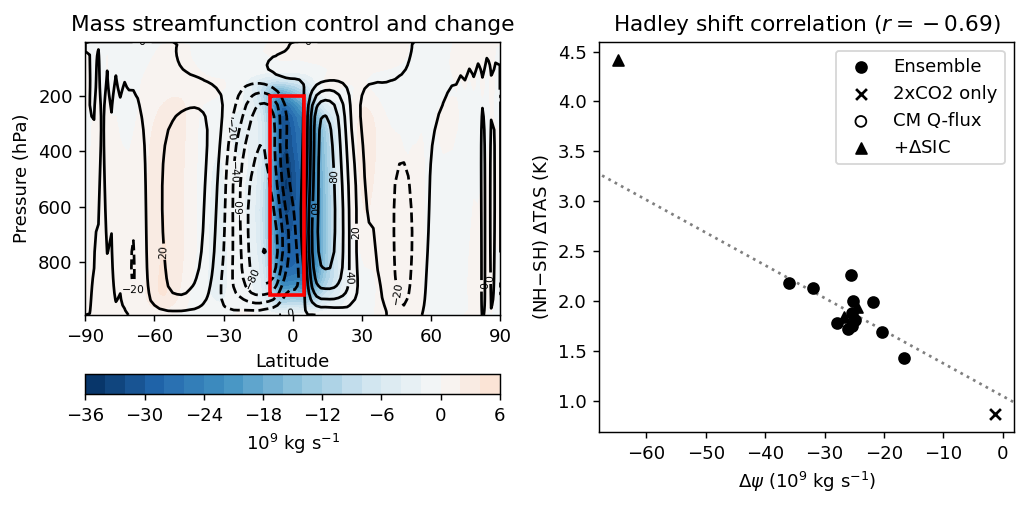

In [29]:
x = np.linspace(-200, 200, 10)
z = np.polyfit(dpsi_mean, (nhmst - shmst), 1)

m, b = z[0], z[1]

fig = plt.figure(figsize=(8, 4), dpi=130)
ax = plt.subplot(121)
ctrl_psi = ax.contour(psi_ctrl.lat, psi_ctrl.lev, psi_ctrl.T, colors='k', levels=10)
plt.clabel(ctrl_psi, fontsize=6)
dplot = ax.contourf(dpsi.lat, dpsi.lev, dpsi.mean(dim='model').T, cmap='RdBu_r', levels=20, norm=colors.CenteredNorm())
ax.add_patch(mpatches.Rectangle([-10, 200], 15, 720, edgecolor='r', facecolor='none', linewidth=2, linestyle='-', zorder=3))
plt.gca().invert_yaxis()
plt.colorbar(dplot, label='10$^9$ kg s$^{-1}$', orientation='horizontal')
plt.xlabel('Latitude')
plt.ylabel('Pressure (hPa)')
plt.xticks([-90, -60, -30, 0, 30, 60, 90]);
ax.set_title('Mass streamfunction control and change')

ax_s = plt.subplot(122)
ax_s.scatter(dpsi_mean, (nhmst - shmst), color='k', label='Ensemble')
ax_s.scatter(dpsi_co2_mean, (nhmst_co2 - shmst_co2), marker='x', color='k', label='2xCO2 only')
ax_s.scatter(dpsi_em_mean, (nhmst_em - shmst_em), facecolor='none', edgecolor='k', label='CM Q-flux')
ax_s.scatter(dpsi_cold_mean, (nhmst_cold - shmst_cold), color='k', marker='^', label='+$\Delta$SIC')
xlim, ylim = ax_s.get_xlim(), ax_s.get_ylim()
ax_s.plot(x, m*x+b, color='k', linestyle=':', alpha=0.5)
ax_s.legend()

ax_s.set_xlim(xlim)
ax_s.set_ylim(ylim)
ax_s.set_xlabel('$\Delta\psi$ (10$^9$ kg s$^{-1}$)')
ax_s.set_ylabel('(NH$-$SH) $\Delta$TAS (K)')
ax_s.set_title('Hadley shift correlation ($r=%.2f$)' %pearsonr(dpsi_mean, (nhmst - shmst))[0])

plt.tight_layout()

## Figure 7: Low cloud cover

Calculate change in LCC:

In [30]:
dlcc = response.CLDLOW*100 - ctrl.CLDLOW*100
em_lcc = resp_em.CLDLOW*100 - ctrl.CLDLOW*100
co2_lcc = resp_co2.CLDLOW*100 - ctrl.CLDLOW*100
cold_lcc = resp_cold.CLDLOW*100 - ctrl.CLDLOW*100

Calculate change in liquid water path (not plotted in paper):

In [31]:
dlwp = response.TGCLDLWP - ctrl.TGCLDLWP
em_lwp = resp_em.TGCLDLWP - ctrl.TGCLDLWP
co2_lwp = resp_co2.TGCLDLWP - ctrl.TGCLDLWP
cold_lwp = resp_cold.TGCLDLWP - ctrl.TGCLDLWP

The plot:

In [32]:
# cyclic_dlcc_mean = add_cyclic_point(dlcc.mean(dim='model'), dim='lon', period=360)

# fig = plt.figure(figsize=(9, 4), dpi=130)
# ax_mean = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
# mean_plot = ax_mean.contourf(cyclic_dlcc_mean.lon, cyclic_dlcc_mean.lat, cyclic_dlcc_mean, cmap='RdBu_r', levels=np.arange(-10, 15), norm=colors.CenteredNorm())
# ax_mean.add_patch(mpatches.Polygon(xy=[[213.333, 10], [285, 10], [285, -43.75]], facecolor='none', edgecolor='slateblue', linewidth=2, alpha=1, transform=ccrs.PlateCarree()))
# ax_mean.add_patch(mpatches.Rectangle(xy=[-180, -60], width=361, height=30, facecolor='none', edgecolor='k', linewidth=2, alpha=1, transform=ccrs.PlateCarree()))
# ax_mean.coastlines(linewidth=0.75)
# ax_mean.set_xticks([-120, -60, 0, 60, 120], crs=ccrs.PlateCarree())
# ax_mean.set_yticks([-60, -30, 0, 30, 60], crs=ccrs.PlateCarree())
# plt.colorbar(mean_plot, orientation='vertical', label='$\Delta$LCC (%)', shrink=0.78, pad=0.013)

# divider = make_axes_locatable(ax_mean)
# ax3 = divider.new_horizontal(size="30%", pad=0.1, axes_class=plt.Axes)
# fig.add_axes(ax3)
# ax3.set_yticks([])
    
# ax3.plot(0*cyclic_dlcc_mean.lat, cyclic_dlcc_mean.lat, color='gray', linestyle='-')

# for j, m in enumerate(dlcc.model):
#     ax3.plot((dlcc).sel(model=m).mean(dim='lon'), dlcc.lat, color=plt.cm.viridis(((gmst-gmst.min())/(gmst-gmst.min()).max())[j]), alpha=0.5)

# mz_plot = ax3.plot(cyclic_dlcc_mean.mean(dim='lon'), cyclic_dlcc_mean.lat, 'k', linewidth=2.5, label='Ens. mean')
# mzco2_plot = ax3.plot(co2_lcc.mean(dim='lon'), co2_lcc.lat, 'r', linestyle='--', label='2xCO2 only')
# mzem_plot = ax3.plot(em_lcc.mean(dim='lon'), em_lcc.lat, 'b', linestyle='--', label='CM Q-flux')

# for j, m in enumerate(cold_lcc.model):
#     if j == 0:
#         ax3.plot((cold_lcc).sel(model=m).mean(dim='lon'), dlcc.lat, color='cornflowerblue', linestyle='--', alpha=0.5, label='+$\Delta$SIC')
#     elif j != 0:
#         ax3.plot((cold_lcc).sel(model=m).mean(dim='lon'), dlcc.lat, color='cornflowerblue', linestyle='--', alpha=0.5)

# ax3.set_ylim(-90, 90)
# ax3.set_xlabel('%')
# plt.legend(loc='upper right')

# plt.suptitle('Ensemble- and zonal-mean change in low cloud cover', y=0.86)
# plt.tight_layout()

Text(0.5, 1.0, '$+\\Delta$SIC-mean change in LCC')

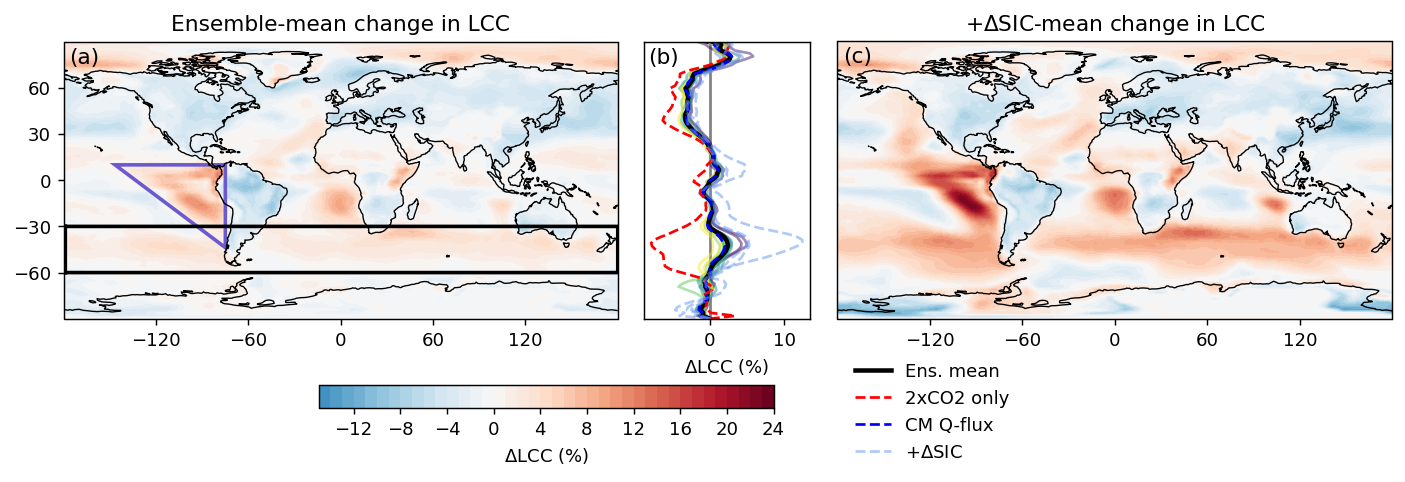

In [33]:
cyclic_dlcc_mean = add_cyclic_point(dlcc.mean(dim='model'), dim='lon', period=360)
cyclic_cold_dlcc_mean = add_cyclic_point(cold_lcc.mean(dim='model'), dim='lon', period=360)

fig = plt.figure(dpi=130, figsize=(14, 7))

ax = fig.add_axes([0, 0.5, 0.41, 0.4], projection=ccrs.PlateCarree())

divider = make_axes_locatable(ax)
axz = divider.new_horizontal(size="30%", pad=0.2, axes_class=plt.Axes)
fig.add_axes(axz)
axz.set_yticks([])

axc = fig.add_axes([0.425, 0.5, 0.305, 0.4], projection=ccrs.PlateCarree())

axcb = fig.add_axes([0.14, 0.45, 0.25, 0.025])

mean_plot = ax.contourf(cyclic_dlcc_mean.lon, cyclic_dlcc_mean.lat, cyclic_dlcc_mean, cmap='RdBu_r', levels=np.arange(-15, 25), norm=colors.CenteredNorm())
ax.add_patch(mpatches.Polygon(xy=[[213.333, 10], [285, 10], [285, -43.75]], facecolor='none', edgecolor='slateblue', linewidth=2, alpha=1, transform=ccrs.PlateCarree()))
ax.add_patch(mpatches.Rectangle(xy=[-180, -60], width=361, height=30, facecolor='none', edgecolor='k', linewidth=2, alpha=1, transform=ccrs.PlateCarree()))
ax.coastlines(linewidth=0.75)
ax.set_xticks([-120, -60, 0, 60, 120], crs=ccrs.PlateCarree())
ax.set_yticks([-60, -30, 0, 30, 60], crs=ccrs.PlateCarree())

axz.plot(0*cyclic_dlcc_mean.lat, cyclic_dlcc_mean.lat, color='gray', linestyle='-')

for j, m in enumerate(dlcc.model):
    axz.plot((dlcc).sel(model=m).mean(dim='lon'), dlcc.lat, color=plt.cm.viridis(((gmst-gmst.min())/(gmst-gmst.min()).max())[j]), alpha=0.5)

mz_plot = axz.plot(dlcc.mean(dim=['model', 'lon']), dlcc.lat, 'k', linewidth=2.5, label='Ens. mean')
mzco2_plot = axz.plot(co2_lcc.mean(dim='lon'), co2_lcc.lat, 'r', linestyle='--', label='2xCO2 only')
mzem_plot = axz.plot(em_lcc.mean(dim='lon'), em_lcc.lat, 'b', linestyle='--', label='CM Q-flux')

for j, m in enumerate(cold_lcc.model):
    if j == 0:
        axz.plot((cold_lcc).sel(model=m).mean(dim='lon'), dlcc.lat, color='cornflowerblue', linestyle='--', alpha=0.5, label='+$\Delta$SIC')
    elif j != 0:
        axz.plot((cold_lcc).sel(model=m).mean(dim='lon'), dlcc.lat, color='cornflowerblue', linestyle='--', alpha=0.5)

cold_plot = axc.contourf(cyclic_cold_dlcc_mean.lon, cyclic_cold_dlcc_mean.lat, cyclic_cold_dlcc_mean, cmap='RdBu_r', levels=np.arange(-15, 25), 
                         norm=colors.CenteredNorm())
axc.coastlines(linewidth=0.75)
axc.set_xticks([-120, -60, 0, 60, 120], crs=ccrs.PlateCarree())

plt.colorbar(cold_plot, cax=axcb, orientation='horizontal', label='$\Delta$LCC (%)')

axz.set_ylim(-90, 90)
axz.set_xlabel('$\Delta$LCC (%)')
axz.legend(frameon=False, prop = {'size': 10}, bbox_to_anchor=(2.3, -0.1))
ax.text(.01, .98, '(a)', ha='left', va='top', transform=ax.transAxes, fontsize=12)
axz.text(1.055, .98, '(b)', ha='left', va='top', transform=ax.transAxes, fontsize=12)
axc.text(.01, .98, '(c)', ha='left', va='top', transform=axc.transAxes, fontsize=12)

ax.set_title('Ensemble-mean change in LCC')
axc.set_title('$+\Delta$SIC-mean change in LCC')

# SE Atlantic box
# ax.add_patch(mpatches.Rectangle(xy=[-17, -30], width=30, height=30, facecolor='none', edgecolor='g', linewidth=2, alpha=1, transform=ccrs.PlateCarree()))

Text(0.5, 1.0, '$+\\Delta$SIC-mean change in lwp')

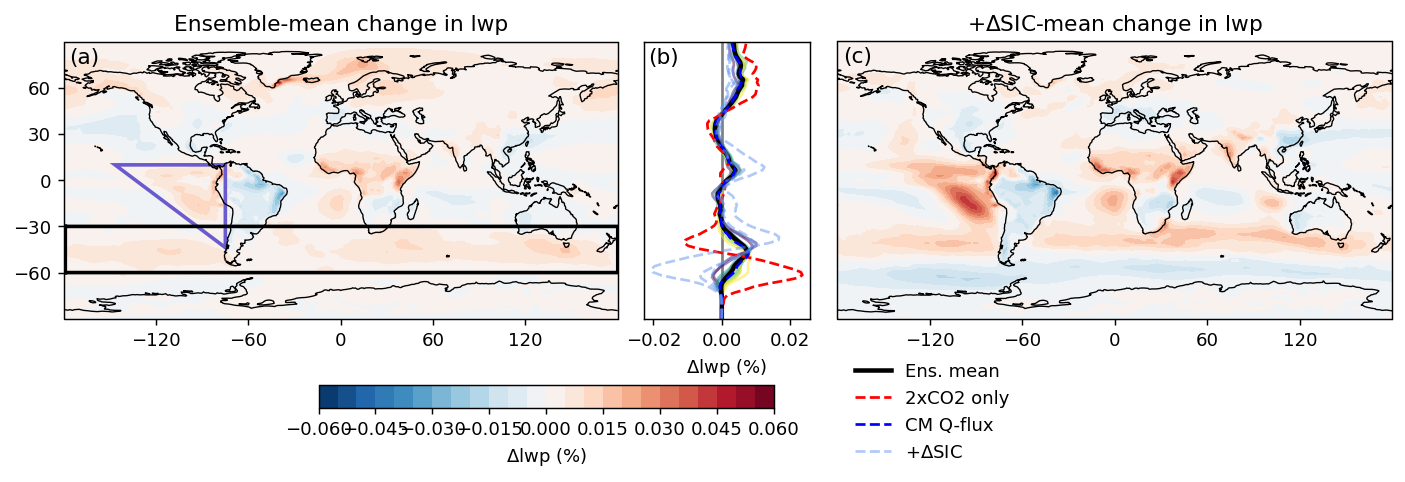

In [34]:
cyclic_dlwp_mean = add_cyclic_point(dlwp.mean(dim='model'), dim='lon', period=360)
cyclic_cold_dlwp_mean = add_cyclic_point(cold_lwp.mean(dim='model'), dim='lon', period=360)

fig = plt.figure(dpi=130, figsize=(14, 7))

ax = fig.add_axes([0, 0.5, 0.41, 0.4], projection=ccrs.PlateCarree())

divider = make_axes_locatable(ax)
axz = divider.new_horizontal(size="30%", pad=0.2, axes_class=plt.Axes)
fig.add_axes(axz)
axz.set_yticks([])

axc = fig.add_axes([0.425, 0.5, 0.305, 0.4], projection=ccrs.PlateCarree())

axcb = fig.add_axes([0.14, 0.45, 0.25, 0.025])

mean_plot = ax.contourf(cyclic_dlwp_mean.lon, cyclic_dlwp_mean.lat, cyclic_dlwp_mean, cmap='RdBu_r', levels=np.arange(-0.06, 0.061, 0.005), norm=colors.CenteredNorm())
ax.add_patch(mpatches.Polygon(xy=[[213.333, 10], [285, 10], [285, -43.75]], facecolor='none', edgecolor='slateblue', linewidth=2, alpha=1, transform=ccrs.PlateCarree()))
ax.add_patch(mpatches.Rectangle(xy=[-180, -60], width=361, height=30, facecolor='none', edgecolor='k', linewidth=2, alpha=1, transform=ccrs.PlateCarree()))
ax.coastlines(linewidth=0.75)
ax.set_xticks([-120, -60, 0, 60, 120], crs=ccrs.PlateCarree())
ax.set_yticks([-60, -30, 0, 30, 60], crs=ccrs.PlateCarree())

axz.plot(0*cyclic_dlwp_mean.lat, cyclic_dlwp_mean.lat, color='gray', linestyle='-')

for j, m in enumerate(dlwp.model):
    axz.plot((dlwp).sel(model=m).mean(dim='lon'), dlwp.lat, color=plt.cm.viridis(((gmst-gmst.min())/(gmst-gmst.min()).max())[j]), alpha=0.5)

mz_plot = axz.plot(dlwp.mean(dim=['model', 'lon']), dlwp.lat, 'k', linewidth=2.5, label='Ens. mean')
mzco2_plot = axz.plot(co2_lwp.mean(dim='lon'), co2_lwp.lat, 'r', linestyle='--', label='2xCO2 only')
mzem_plot = axz.plot(em_lwp.mean(dim='lon'), em_lwp.lat, 'b', linestyle='--', label='CM Q-flux')

for j, m in enumerate(cold_lwp.model):
    if j == 0:
        axz.plot((cold_lwp).sel(model=m).mean(dim='lon'), dlwp.lat, color='cornflowerblue', linestyle='--', alpha=0.5, label='+$\Delta$SIC')
    elif j != 0:
        axz.plot((cold_lwp).sel(model=m).mean(dim='lon'), dlwp.lat, color='cornflowerblue', linestyle='--', alpha=0.5)

cold_plot = axc.contourf(cyclic_cold_dlwp_mean.lon, cyclic_cold_dlwp_mean.lat, cyclic_cold_dlwp_mean, cmap='RdBu_r', levels=np.arange(-0.06, 0.061, 0.005), 
                         norm=colors.CenteredNorm())
axc.coastlines(linewidth=0.75)
axc.set_xticks([-120, -60, 0, 60, 120], crs=ccrs.PlateCarree())

plt.colorbar(cold_plot, cax=axcb, orientation='horizontal', label='$\Delta$lwp (%)')

axz.set_ylim(-90, 90)
axz.set_xlabel('$\Delta$lwp (%)')
axz.legend(frameon=False, prop = {'size': 10}, bbox_to_anchor=(2.3, -0.1))
ax.text(.01, .98, '(a)', ha='left', va='top', transform=ax.transAxes, fontsize=12)
axz.text(1.055, .98, '(b)', ha='left', va='top', transform=ax.transAxes, fontsize=12)
axc.text(.01, .98, '(c)', ha='left', va='top', transform=axc.transAxes, fontsize=12)

ax.set_title('Ensemble-mean change in lwp')
axc.set_title('$+\Delta$SIC-mean change in lwp')

## Figure 8: LCC patch correlation

Calculate regional-average LCC changes:

In [35]:
eptri_lcc = global_average(dlcc.where(((dlcc.lat + 0.75*dlcc.lon) > 170) & (dlcc.lat < 10) & (dlcc.lon < 285)))
smid_lcc = global_average(dlcc.where((dlcc.lat < -30) & (dlcc.lat > -60)))

eptri_cold_lcc = global_average(cold_lcc.where(((cold_lcc.lat + 0.75*cold_lcc.lon) > 170) & (cold_lcc.lat < 10) & (cold_lcc.lon < 285)))
smid_cold_lcc = global_average(cold_lcc.where((cold_lcc.lat < -30) & (cold_lcc.lat > -60)))

eptri_em_lcc = global_average(em_lcc.where(((em_lcc.lat + 0.75*em_lcc.lon) > 170) & (em_lcc.lat < 10) & (em_lcc.lon < 285)))
smid_em_lcc = global_average(em_lcc.where((em_lcc.lat < -30) & (em_lcc.lat > -60)))

eptri_co2_lcc = global_average(co2_lcc.where(((co2_lcc.lat + 0.75*co2_lcc.lon) > 170) & (co2_lcc.lat < 10) & (co2_lcc.lon < 285)))
smid_co2_lcc = global_average(co2_lcc.where((co2_lcc.lat < -30) & (co2_lcc.lat > -60)))

In [36]:
ecs = global_average(ecs_map)
cold_tcr = global_average(cold_tcr_map)

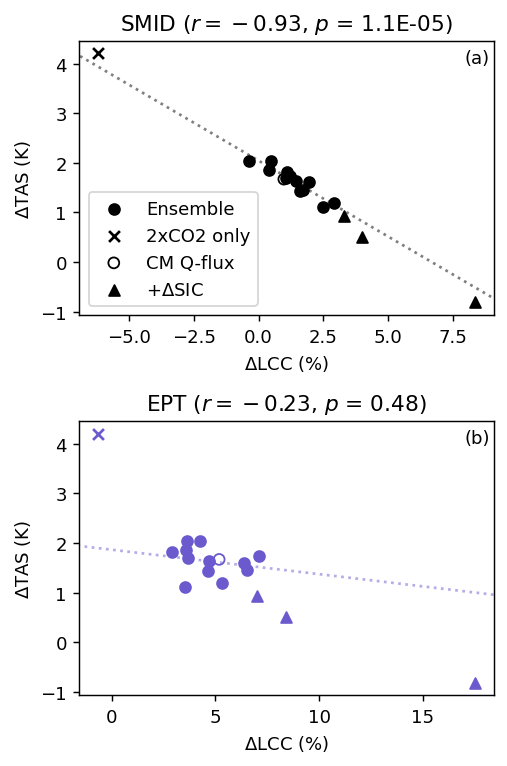

In [37]:
fig2 = plt.figure(figsize=(4, 6), dpi=130)

x = np.linspace(-10, 20, 20)

z1 = np.polyfit(smid_lcc, tcr, 1)
m1, b1 = z1[0], z1[1]

ax1 = plt.subplot(2, 1, 1)
ax1.scatter(smid_lcc, tcr, color='k', label='Ensemble')
ax1.scatter(smid_co2_lcc, ecs, color='k', marker='x', label='2xCO2 only')
ax1.scatter(smid_em_lcc, em_tcr, color='k', facecolors='none', label='CM Q-flux')
ax1.scatter(smid_cold_lcc, cold_tcr, color='k', marker='^', label='+$\Delta$SIC')
ax1.set_ylabel('$\Delta$TAS (K)')
ax1.set_xlabel('$\Delta$LCC (%)')
ax1.set_title(('SMID ($r = %.2f$, $p$ = %.1E)' %(pearsonr(smid_lcc, gmst)[0], pearsonr(smid_lcc, gmst)[1])))
xlim, ylim = ax1.get_xlim(), ax1.get_ylim()
ax1.plot(x, m1*x+b1, color='k', linestyle=':', alpha=0.5)
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.legend(loc='lower left')

z3 = np.polyfit(eptri_lcc, tcr, 1)
m3, b3 = z3[0], z3[1]

ax3 = plt.subplot(2, 1, 2)
ax3.scatter(eptri_lcc, tcr, color='slateblue')
ax3.scatter(eptri_cold_lcc, cold_tcr, color='slateblue', marker='^')
ax3.scatter(eptri_em_lcc, em_tcr, color='slateblue', facecolors='none')
ax3.scatter(eptri_co2_lcc, ecs, color='slateblue', marker='x')
ax3.set_ylabel('$\Delta$TAS (K)')
ax3.set_xlabel('$\Delta$LCC (%)')
ax3.set_title(('EPT ($r = %.2f$, $p$ = %.2f)' %(pearsonr(eptri_lcc, gmst)[0], pearsonr(eptri_lcc, gmst)[1])))
xlim3, ylim3 = ax3.get_xlim(), ax3.get_ylim()
ax3.plot(x, m3*x+b3, color='slateblue', linestyle=':', alpha=0.5)
ax3.set_xlim(xlim3)
ax3.set_ylim(ylim3)

# ax2 = plt.subplot(3, 1, 2, projection=ccrs.PlateCarree(central_longitude=0))
# ax2.set_extent([0, 359, -90, 90], crs=ccrs.PlateCarree(central_longitude=0))
# ax2.add_patch(mpatches.Polygon(xy=[[213.333, 10], [285, 10], [285, -43.75]], facecolor='slateblue', edgecolor='slateblue', alpha=0.75, transform=ccrs.PlateCarree()))
# ax2.add_patch(mpatches.Rectangle(xy=[-180, -60], width=361, height=30, facecolor='k', edgecolor='k', alpha=0.75, transform=ccrs.PlateCarree()))
# ax2.coastlines(linewidth=0.5)

ax1.text(.99, .97, '(a)', ha='right', va='top', transform=ax1.transAxes)
ax3.text(.99, .97, '(b)', ha='right', va='top', transform=ax3.transAxes)

plt.tight_layout()

## Figure 9: Cloud-controlling factors

Calculate change in cloud-controlling factors:

In [38]:
w500_tcr = response.OMEGA.sel(lev=500, method='nearest') - ctrl.OMEGA.sel(lev=500, method='nearest')
w500_em = resp_em.OMEGA.sel(lev=500, method='nearest') - ctrl.OMEGA.sel(lev=500, method='nearest')
w500_co2 = resp_co2.OMEGA.sel(lev=500, method='nearest') - ctrl.OMEGA.sel(lev=500, method='nearest')
w500_cold = resp_cold.OMEGA.sel(lev=500, method='nearest') - ctrl.OMEGA.sel(lev=500, method='nearest')

u10_tcr = response.U10 - ctrl.U10
u10_em = resp_em.U10 - ctrl.U10
u10_co2 = resp_co2.U10 - ctrl.U10
u10_cold = resp_cold.U10 - ctrl.U10

ts_tcr = response.TS - ctrl.TS
ts_em = resp_em.TS - ctrl.TS
ts_co2 = resp_co2.TS - ctrl.TS
ts_cold = resp_cold.TS - ctrl.TS

eis_response = EIS(response.TS, response.T.sel(lev=700, method='nearest'))
eis_em_resp = EIS(resp_em.TS, resp_em.T.sel(lev=700, method='nearest'))
eis_co2_resp = EIS(resp_co2.TS, resp_co2.T.sel(lev=700, method='nearest'))
eis_ctrl = EIS(ctrl.TS, ctrl.T.sel(lev=700, method='nearest'))
eis_cold_resp = EIS(resp_cold.TS, resp_cold.T.sel(lev=700, method='nearest'))

eis_tcr = eis_response - eis_ctrl
eis_em = eis_em_resp - eis_ctrl
eis_co2 = eis_co2_resp - eis_ctrl
eis_cold = eis_cold_resp - eis_ctrl

Functions to calculate Southern Hemisphere midlatitude average and plot trend lines:

In [39]:
def smid(da):
    return global_average(da.where((da.lat > -60) & (da.lat < -30)))

def esmid(da):
    return global_average(da.where((da.lat > -45) & (da.lat < -30)))

def plot_trend(ax, x, y):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    xrange = np.arange(-10, 10, 1)
    z = np.polyfit(x, y, 1)
    m, b = z[0], z[1]
    ax.plot(xrange, m*xrange+b, color='k', linestyle=':', alpha=0.5)
    
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)

The plot:

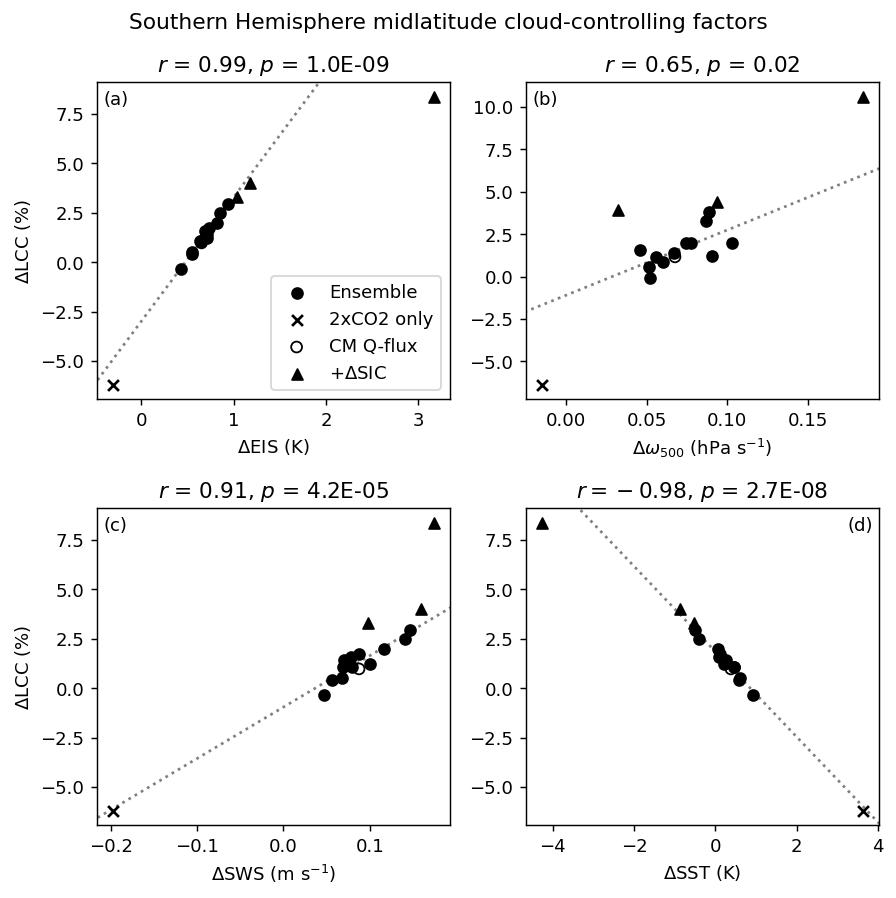

In [40]:
fig = plt.figure(figsize=(7, 7), dpi=130)

ax1 = fig.add_subplot(2, 2, 1)
ax1.scatter(smid(eis_tcr), smid(dlcc), color='k', label='Ensemble')
ax1.scatter(smid(eis_co2), smid(co2_lcc), color='k', marker='x', label='2xCO2 only')
ax1.scatter(smid(eis_em), smid(em_lcc), color='k', facecolors='none', label='CM Q-flux')
ax1.scatter(smid(eis_cold), smid(cold_lcc), color='k', marker='^', label='+$\Delta$SIC')
plot_trend(ax1, smid(eis_tcr), smid_lcc)
ax1.set_title(('$r$ = %.2f, $p$ = %.1E' %(pearsonr(smid(eis_tcr), smid_lcc)[0], pearsonr(smid(eis_tcr), smid_lcc)[1])))
plt.legend()

ax2 = fig.add_subplot(2, 2, 2)
ax2.scatter(esmid(w500_tcr)*100, esmid(dlcc), color='k')
ax2.scatter(esmid(w500_em)*100, esmid(em_lcc), color='k', facecolors='none')
ax2.scatter(esmid(w500_co2)*100, esmid(co2_lcc), color='k', marker='x')
ax2.scatter(esmid(w500_cold)*100, esmid(cold_lcc), color='k', marker='^')
plot_trend(ax2, esmid(w500_tcr)*100, esmid(dlcc))
ax2.set_title(('$r$ = %.2f, $p$ = %.2f' %(pearsonr(esmid(w500_tcr), esmid(dlcc))[0], pearsonr(esmid(w500_tcr), esmid(dlcc))[1])))

ax3 = fig.add_subplot(2, 2, 3)
ax3.scatter(smid(u10_tcr), smid(dlcc), color='k')
ax3.scatter(smid(u10_em), smid(em_lcc), color='k', facecolors='none')
ax3.scatter(smid(u10_co2), smid(co2_lcc), color='k', marker='x')
ax3.scatter(smid(u10_cold), smid(cold_lcc), color='k', marker='^')
plot_trend(ax3, smid(u10_tcr), smid_lcc)
ax3.set_title(('$r$ = %.2f, $p$ = %.1E' %(pearsonr(smid(u10_tcr), smid_lcc)[0], pearsonr(smid(u10_tcr), smid_lcc)[1])))

ax4 = fig.add_subplot(2, 2, 4)
ax4.scatter(smid(ts_tcr), smid(dlcc), color='k')
ax4.scatter(smid(ts_em), smid(em_lcc), color='k', facecolors='none')
ax4.scatter(smid(ts_co2), smid(co2_lcc), color='k', marker='x')
ax4.scatter(smid(ts_cold), smid(cold_lcc), color='k', marker='^')
plot_trend(ax4, smid(ts_tcr), smid_lcc)
ax4.set_title(('$r = %.2f$, $p$ = %.1E' %(pearsonr(smid(ts_tcr), smid_lcc)[0], pearsonr(smid(ts_tcr), smid_lcc)[1])))

# .replace("-", u"\u2212")

ax1.set_ylabel('$\Delta$LCC (%)')
ax3.set_ylabel('$\Delta$LCC (%)')
ax1.set_xlabel('$\Delta$EIS (K)')
ax2.set_xlabel('$\Delta\omega_{500}$ (hPa s$^{-1}$)')
ax3.set_xlabel('$\Delta$SWS (m s$^{-1}$)')
ax4.set_xlabel('$\Delta$SST (K)')

ax1.text(.02, .975, '(a)', ha='left', va='top', transform=ax1.transAxes)
ax2.text(.02, .975, '(b)', ha='left', va='top', transform=ax2.transAxes)
ax3.text(.02, .975, '(c)', ha='left', va='top', transform=ax3.transAxes)
ax4.text(.985, .975, '(d)', ha='right', va='top', transform=ax4.transAxes)

fig.suptitle('Southern Hemisphere midlatitude cloud-controlling factors')
plt.tight_layout()

## Figure 10: Eddy kinetic energy

Calculate total kinetic energy (`tke`) and subtract out time-averaged kinetic energy to get eddy kinetic energy (`eke`):

In [41]:
tke = 0.5*(response.UU + response.VV)
tke_cold = 0.5*(resp_cold.UU + resp_cold.VV)
tke_ctrl = 0.5*(ctrl.UU + ctrl.VV)
tke_co2 = 0.5*(resp_co2.UU + resp_co2.VV)
tke_em = 0.5*(resp_em.UU + resp_em.VV)

eke = tke - 0.5*(response.U**2 + response.V**2)
eke_cold = tke_cold - 0.5*(resp_cold.U**2 + resp_cold.V**2)
eke_ctrl = tke_ctrl - 0.5*(ctrl.U**2 + ctrl.V**2)
eke_co2 = tke_co2 - 0.5*(resp_co2.U**2 + resp_co2.V**2)
eke_em = tke_em - 0.5*(resp_em.U**2 + resp_em.V**2)

Integrate (sum) EKE between two specified pressures:

In [42]:
max_lev = 250
min_lev = 850

int_eke = eke.where((eke.lev > max_lev) & (eke.lev < min_lev)).sum(dim='lev')
int_eke_cold = eke_cold.where((eke_cold.lev > max_lev) & (eke_cold.lev < min_lev)).sum(dim='lev')
int_eke_ctrl = eke_ctrl.where((eke_ctrl.lev > max_lev) & (eke_ctrl.lev < min_lev)).sum(dim='lev')
int_eke_co2 = eke_co2.where((eke_co2.lev > max_lev) & (eke_co2.lev < min_lev)).sum(dim='lev')
int_eke_em = eke_em.where((eke_em.lev > max_lev) & (eke_em.lev < min_lev)).sum(dim='lev')

Function for NH midlatitude averages:

In [43]:
def nmid(da):
    return global_average(da.where((da.lat > 30) & (da.lat < 60)))

Calculate NH midlatitude LCC changes:

In [44]:
nmid_lcc = nmid(dlcc)
nmid_cold_lcc = nmid(cold_lcc)
nmid_em_lcc = nmid(em_lcc)
nmid_co2_lcc = nmid(co2_lcc)

Calculate changes in EKE:

In [45]:
eke_diff = int_eke - int_eke_ctrl
cold_eke_diff = int_eke_cold - int_eke_ctrl
em_eke_diff = int_eke_em - int_eke_ctrl
co2_eke_diff = int_eke_co2 - int_eke_ctrl

Midlatitude averages:

In [46]:
smid_eke_diff = smid(eke_diff)
nmid_eke_diff = nmid(eke_diff)

cold_smid_eke_diff = smid(cold_eke_diff)
cold_nmid_eke_diff = nmid(cold_eke_diff)

em_smid_eke_diff = smid(em_eke_diff)
em_nmid_eke_diff = nmid(em_eke_diff)

co2_smid_eke_diff = smid(co2_eke_diff)
co2_nmid_eke_diff = nmid(co2_eke_diff)

The plot:

In [47]:
# fig = plt.figure(figsize=(14, 3), dpi=130)

# cyclic_eke_diff = add_cyclic_point(eke_diff, dim='lon', period=360)

# ax_mean = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
# mean_plot = ax_mean.contourf(cyclic_eke_diff.lon, cyclic_eke_diff.lat, cyclic_eke_diff.mean(dim='model'), cmap='RdBu_r', levels=21, norm=colors.CenteredNorm())
# ax_mean.coastlines()
# ax_mean.add_patch(mpatches.Rectangle(xy=[-180, 30], width=361, height=30, facecolor='none', edgecolor='g', linewidth=2, alpha=1, transform=ccrs.PlateCarree()))
# ax_mean.add_patch(mpatches.Rectangle(xy=[-180, -60], width=361, height=30, facecolor='none', edgecolor='k', linewidth=2, alpha=1, transform=ccrs.PlateCarree()))
# ax_mean.set_xticks([-120, -60, 0, 60, 120], crs=ccrs.PlateCarree())
# ax_mean.set_yticks([-60, -30, 0, 30, 60], crs=ccrs.PlateCarree())
# ax_mean.set_title('Ensemble-mean change in column-integrated EKE')

# divider = make_axes_locatable(ax_mean)
# ax_cb = divider.new_vertical(size="5%", pad=-3.3, axes_class=plt.Axes)
# plt.colorbar(mean_plot, cax=ax_cb, orientation='horizontal', label='m$^2$ s$^{-2}$')
# fig.add_axes(ax_cb)

# x = np.linspace(-200, 200, 10)
# z1 = np.polyfit(smid_eke_diff, smid_lcc, 1)
# z2 = np.polyfit(nmid_eke_diff, nmid_lcc, 1)

# m1, b1 = z1[0], z1[1]
# m2, b2 = z2[0], z2[1]

# ax_z = divider.new_horizontal(size="30%", pad=0.1, axes_class=plt.Axes)
# fig.add_axes(ax_z)
# ax_z.set_yticks([])

# ax_z.vlines(0, -90, 90, color='gray')
# for j, m in enumerate(int_eke.model):
#     ax_z.plot((int_eke - int_eke_ctrl).sel(model=m).mean(dim='lon'), int_eke.lat, color=plt.cm.viridis(((tcr-tcr.min())/(tcr-tcr.min()).max())[j]), alpha=0.5)

    
# ax_z.plot(eke_diff.mean(dim=['lon', 'model']), int_eke.lat, 'k', linestyle='-', label='Ens. mean')
# ax_z.plot(co2_eke_diff.mean(dim='lon'), int_eke_co2.lat, 'r', linestyle='--', label='2xCO2 only')
# ax_z.plot(em_eke_diff.mean(dim='lon'), int_eke_em.lat, 'b', linestyle='--', label='CM Q-flux')

# for j, m in enumerate(int_eke_cold.model):
#     if j == 0:
#         ax_z.plot(cold_eke_diff.sel(model=m).mean(dim='lon'), int_eke_cold.lat, color='cornflowerblue', linestyle='--', alpha=0.5, label='+$\Delta$SIC')
#     elif j != 0:
#         ax_z.plot(cold_eke_diff.sel(model=m).mean(dim='lon'), int_eke_cold.lat, color='cornflowerblue', linestyle='--', alpha=0.5)
        
# ax_z.set_ylim(-90, 90)
# ax_z.set_xlabel('m$^2$ s$^{-2}$')
# plt.legend()

# ax_sc = divider.new_horizontal(size="50%", pad=0.7, axes_class=plt.Axes)
# fig.add_axes(ax_sc)
# ax_sc.scatter(smid_eke_diff, smid_lcc, color='k', marker='o', label='Ensemble')
# ax_sc.scatter(nmid_eke_diff, nmid_lcc, color='g', marker='o')
# ax_sc.scatter(co2_smid_eke_diff, smid_co2_lcc, color='k', marker='x', label='2xCO2 only')
# ax_sc.scatter(co2_nmid_eke_diff, nmid_co2_lcc, color='g', marker='x')
# ax_sc.scatter(em_smid_eke_diff, smid_em_lcc, edgecolor='k', facecolor='none', label='CM Q-flux')
# ax_sc.scatter(em_nmid_eke_diff, nmid_em_lcc, edgecolor='g', facecolor='none')
# ax_sc.scatter(cold_smid_eke_diff, smid_cold_lcc, color='k', marker='^', label='+$\Delta$SIC')
# ax_sc.scatter(cold_nmid_eke_diff, nmid_cold_lcc, color='g', marker='^')

# plt.legend(loc='lower right', prop = {'size': 9})

# xlim = ax_sc.get_xlim()
# ylim = ax_sc.get_ylim()

# ax_sc.plot(x, m1*x+b1, color='k', linestyle=':', alpha=0.5)
# ax_sc.plot(x, m2*x+b2, color='g', linestyle=':', alpha=0.5)

# ax_sc.set_xlabel('$\Delta$EKE (m$^2$ s$^{-2}$)')
# ax_sc.set_ylabel('$\Delta$LCC (%)')

# smid_pcc, smid_p = pearsonr(smid_eke_diff, smid_lcc)[0:2]
# nmid_pcc, nmid_p = pearsonr(nmid_eke_diff, nmid_lcc)[0:2]
# ax_sc.text(x=-95, y=7.3, s='SMID: $r$ = %.2f, $p$ = %.1E' %(smid_pcc, smid_p), color='k')
# ax_sc.text(x=-95, y=6.3, s='NMID: $r$ = %.2f, $p$ = %.1E' %(nmid_pcc, nmid_p), color='g')

# ax_sc.set_axisbelow(True)
# ax_sc.set_xlim(xlim)
# ax_sc.set_ylim(ylim)

Text(0.5, 1.0, '$+\\Delta$SIC-mean change in EKE')

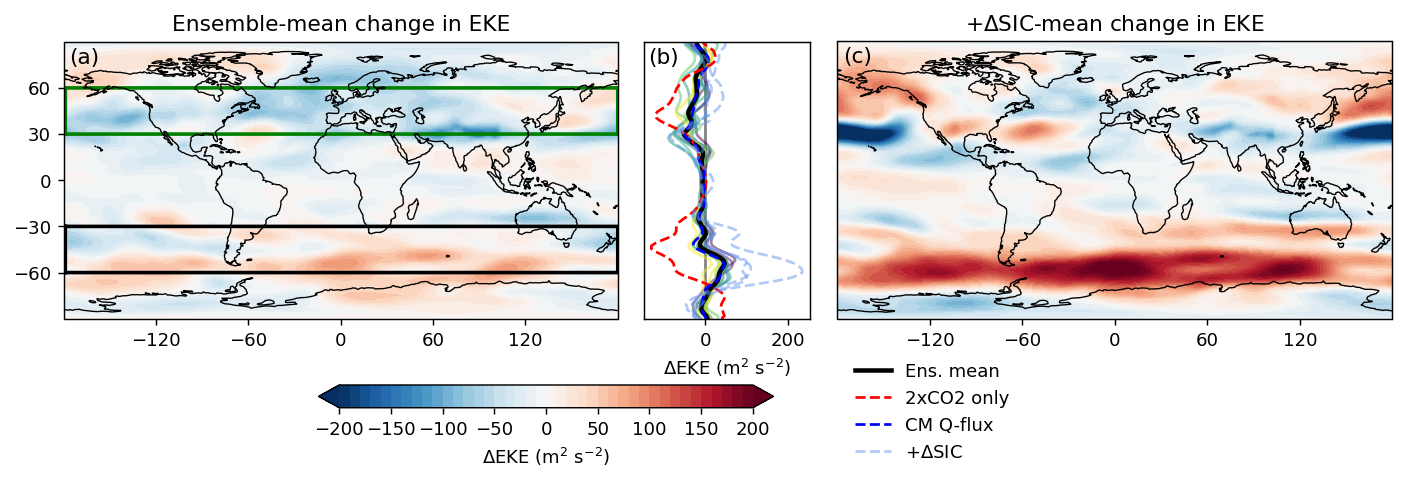

In [48]:
cyclic_eke_diff = add_cyclic_point(eke_diff.mean(dim='model'), dim='lon', period=360)
cyclic_cold_eke_mean = add_cyclic_point(cold_eke_diff.mean(dim='model'), dim='lon', period=360)

fig = plt.figure(dpi=130, figsize=(14, 7))

ax = fig.add_axes([0, 0.5, 0.41, 0.4], projection=ccrs.PlateCarree())

divider = make_axes_locatable(ax)
axz = divider.new_horizontal(size="30%", pad=0.2, axes_class=plt.Axes)
fig.add_axes(axz)
axz.set_yticks([])

axc = fig.add_axes([0.425, 0.5, 0.305, 0.4], projection=ccrs.PlateCarree())

axcb = fig.add_axes([0.14, 0.45, 0.25, 0.025])

mean_plot = ax.contourf(cyclic_eke_diff.lon, cyclic_eke_diff.lat, cyclic_eke_diff, cmap='RdBu_r', levels=np.arange(-200, 201, 10), norm=colors.CenteredNorm(), extend='both')
ax.coastlines(linewidth=0.75)
ax.set_xticks([-120, -60, 0, 60, 120], crs=ccrs.PlateCarree())
ax.set_yticks([-60, -30, 0, 30, 60], crs=ccrs.PlateCarree())
ax.add_patch(mpatches.Rectangle(xy=[-180, 30], width=361, height=30, facecolor='none', edgecolor='g', linewidth=2, alpha=1, transform=ccrs.PlateCarree()))
ax.add_patch(mpatches.Rectangle(xy=[-180, -60], width=361, height=30, facecolor='none', edgecolor='k', linewidth=2, alpha=1, transform=ccrs.PlateCarree()))

axz.plot(0*cyclic_eke_diff.lat, cyclic_eke_diff.lat, color='gray', linestyle='-')

for j, m in enumerate(eke_diff.model):
    axz.plot((eke_diff).sel(model=m).mean(dim='lon'), eke_diff.lat, color=plt.cm.viridis(((gmst-gmst.min())/(gmst-gmst.min()).max())[j]), alpha=0.5)

mz_plot = axz.plot(cyclic_eke_diff.mean(dim='lon'), cyclic_eke_diff.lat, 'k', linewidth=2.5, label='Ens. mean')
mzco2_plot = axz.plot(co2_eke_diff.mean(dim='lon'), co2_eke_diff.lat, 'r', linestyle='--', label='2xCO2 only')
mzem_plot = axz.plot(em_eke_diff.mean(dim='lon'), em_eke_diff.lat, 'b', linestyle='--', label='CM Q-flux')

for j, m in enumerate(cold_eke_diff.model):
    if j == 0:
        axz.plot((cold_eke_diff).sel(model=m).mean(dim='lon'), cold_eke_diff.lat, color='cornflowerblue', linestyle='--', alpha=0.5, label='+$\Delta$SIC')
    elif j != 0:
        axz.plot((cold_eke_diff).sel(model=m).mean(dim='lon'), cold_eke_diff.lat, color='cornflowerblue', linestyle='--', alpha=0.5)

cold_plot = axc.contourf(cyclic_cold_eke_mean.lon, cyclic_cold_eke_mean.lat, cyclic_cold_eke_mean, cmap='RdBu_r', levels=np.arange(-200, 201, 10), 
                         norm=colors.CenteredNorm(), extend='both')
axc.coastlines(linewidth=0.75)
axc.set_xticks([-120, -60, 0, 60, 120], crs=ccrs.PlateCarree())

plt.colorbar(cold_plot, cax=axcb, orientation='horizontal', label='$\Delta$EKE (m$^2$ s$^{-2}$)')

axz.set_ylim(-90, 90)
axz.set_xlabel('$\Delta$EKE (m$^2$ s$^{-2}$)')
axz.legend(frameon=False, prop = {'size': 10}, bbox_to_anchor=(2.3, -0.1))
ax.text(.01, .98, '(a)', ha='left', va='top', transform=ax.transAxes, fontsize=12)
axz.text(1.055, .98, '(b)', ha='left', va='top', transform=ax.transAxes, fontsize=12)
axc.text(.01, .98, '(c)', ha='left', va='top', transform=axc.transAxes, fontsize=12)

ax.set_title('Ensemble-mean change in EKE')
axc.set_title('$+\Delta$SIC-mean change in EKE')

## Figure 11

(-6.914366435261131, 9.090351822691895)

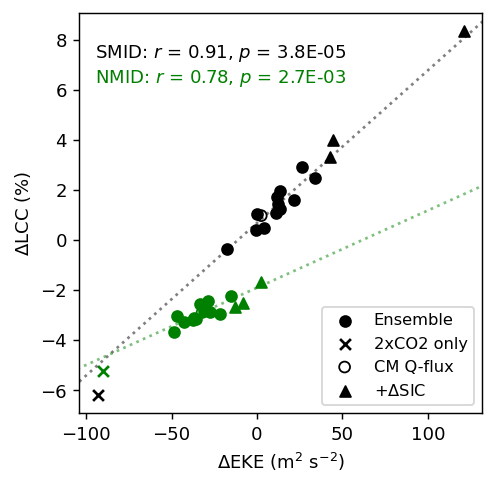

In [49]:
fig = plt.figure(dpi=130, figsize=(4, 4))
ax_sc = fig.add_subplot()

ax_sc.scatter(smid_eke_diff, smid_lcc, color='k', marker='o', label='Ensemble')
ax_sc.scatter(nmid_eke_diff, nmid_lcc, color='g', marker='o')
ax_sc.scatter(co2_smid_eke_diff, smid_co2_lcc, color='k', marker='x', label='2xCO2 only')
ax_sc.scatter(co2_nmid_eke_diff, nmid_co2_lcc, color='g', marker='x')
ax_sc.scatter(em_smid_eke_diff, smid_em_lcc, edgecolor='k', facecolor='none', label='CM Q-flux')
ax_sc.scatter(em_nmid_eke_diff, nmid_em_lcc, edgecolor='g', facecolor='none')
ax_sc.scatter(cold_smid_eke_diff, smid_cold_lcc, color='k', marker='^', label='+$\Delta$SIC')
ax_sc.scatter(cold_nmid_eke_diff, nmid_cold_lcc, color='g', marker='^')

plt.legend(loc='lower right', prop = {'size': 9})

xlim = ax_sc.get_xlim()
ylim = ax_sc.get_ylim()

x = np.linspace(-200, 200, 10)
z1 = np.polyfit(smid_eke_diff, smid_lcc, 1)
z2 = np.polyfit(nmid_eke_diff, nmid_lcc, 1)

m1, b1 = z1[0], z1[1]
m2, b2 = z2[0], z2[1]

ax_sc.plot(x, m1*x+b1, color='k', linestyle=':', alpha=0.5)
ax_sc.plot(x, m2*x+b2, color='g', linestyle=':', alpha=0.5)

ax_sc.set_xlabel('$\Delta$EKE (m$^2$ s$^{-2}$)')
ax_sc.set_ylabel('$\Delta$LCC (%)')

smid_pcc, smid_p = pearsonr(smid_eke_diff, smid_lcc)[0:2]
nmid_pcc, nmid_p = pearsonr(nmid_eke_diff, nmid_lcc)[0:2]
ax_sc.text(x=-95, y=7.3, s='SMID: $r$ = %.2f, $p$ = %.1E' %(smid_pcc, smid_p), color='k')
ax_sc.text(x=-95, y=6.3, s='NMID: $r$ = %.2f, $p$ = %.1E' %(nmid_pcc, nmid_p), color='g')

ax_sc.set_axisbelow(True)
ax_sc.set_xlim(xlim)
ax_sc.set_ylim(ylim)

## Atlantic LCC

(Not plotted in paper)

In [50]:
sea_lcc = global_average(dlcc.where((dlcc.lat < 0) & (dlcc.lat > -30) & ((dlcc.lon > 343) | (dlcc.lon < 13))))
sea_cold_lcc = global_average(cold_lcc.where((cold_lcc.lat < 0) & (cold_lcc.lat > -30) & ((cold_lcc.lon > 343) | (cold_lcc.lon < 13))))
sea_co2_lcc = global_average(co2_lcc.where((co2_lcc.lat < 0) & (co2_lcc.lat > -30) & ((co2_lcc.lon > 343) | (co2_lcc.lon < 13))))

Text(0.5, 1.0, '$r=-0.55$ (12-member ens. only)')

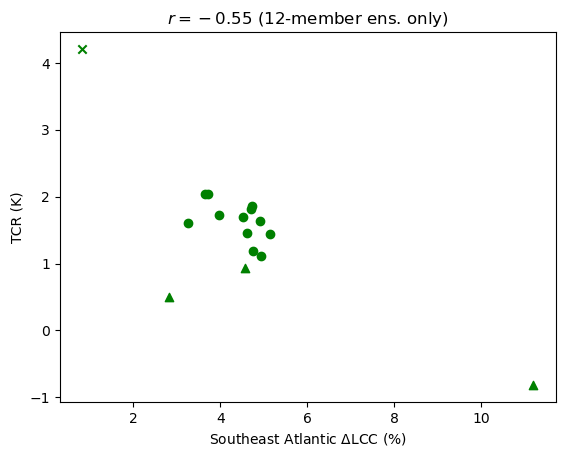

In [51]:
plt.scatter(sea_lcc, tcr, color='g')
plt.scatter(sea_cold_lcc, cold_tcr, color='g', marker='^')
plt.scatter(sea_co2_lcc, ecs, color='g', marker='x')
plt.xlabel('Southeast Atlantic $\Delta$LCC (%)')
plt.ylabel('TCR (K)')
plt.title('$r=%.2f$ (12-member ens. only)' %pearsonr(sea_lcc, tcr)[0])